# Привет! Тут мы анализируем русскоязычные твиты :)

#### Датасет:
https://drive.google.com/drive/folders/0BxlA8wH3PTUfV1F1UTBwVTJPd3c    
#### Необходимые библиотеки
numpy, pandas, scikit-learn, gensim, tensorflow-gpu, keras    
#### Задания:
1. Успешно запустить имеющийся ноутбук
2. Запустить этот же ноутбук на данных ___ttk___
3. Реализовать свёрточную нейронную сеть для анализа твитов:
    - По аналогии с этой статьёй https://www.aclweb.org/anthology/D14-1181.
    - Провести нормализацию текстов (нижний регистр, чистка от пунктуации, приведение к нормальной форме с помощью pymorphy)
    - Использовать эмбеддинги FastText, как в прошлом домашнем задании: http://vectors.nlpl.eu/repository/11/181.zip
4. ***Сдавать это не понадобится, но вам потребуется для задачи DEV:
    - Обернуть ваш код в predictor.py 
    - Сохранить получившиися модели для банков и для телекомов: https://machinelearningmastery.com/save-load-keras-deep-learning-models/

#### _Подсказки_:    
- На вход нейросети будут поступать настаканные друг на друга эмбеддинги поочерёдно каждого слова в тексте.
- Реализацию архитектуры статьи делайте по аналогии с примерами обработки картинок с помощью Sequential, Conv2D, MaxPool, Dense, Dropout из keras.
- Результирующий X для keras будет 4D матрицей (кол-во сэмплов \* максимальная длина текста \* длину вектора эмбеддинга \* 1)    
- padding входных матриц (твиты - переменного размера, а нужно фиксированного, поэтому нужно матрицы добивать нулями или обрезать)    
- Чтобы адаптировать примеры с картинками к примерам с текстами, нужно аккуратно поменять размер рецептивного поля у Conv2D    
- Для keras нужно передавать метки класса в sparse-формате (П: не y=\[0,1,2\], a y=\[\[1,0,0\], \[0,1,0\], \[0,0,1\]\])
- Для улучшения результата можно вектора слов умножать на их Tf-Idf score, можно нормализовать весь X, добавлять Dropout в модель

Если будут вопросы - обращайтесь :)

## I. Импортим нужные библиотеки

In [1]:
import xmltodict
import re

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

## II. Определяем функции с парсингом входных данных

In [4]:
companies = {}
def get_sample_text(sample):
    assert sample['column'][3]['@name'] == 'text'
    return sample['column'][3]['#text']


def get_sample_answers_bank(sample):
    answers = {}
    for i in range(4, 12):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_answers_tkk(sample):
    answers = {}
    for i in range(4, 11):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_id(sample):
    assert sample['column'][0]['@name'] == 'id'
    return int(sample['column'][0]['#text'])


def get_data(filename):
    df = pd.DataFrame()
    with open(filename, "r", encoding='utf-8') as f:
        d = xmltodict.parse(f.read(), process_namespaces=True)
        clean_samples = []
        for sample in d['pma_xml_export']['database']['table']:
            sample_id = get_sample_id(sample)
            text = get_sample_text(sample)
            answers = get_sample_answers_bank(sample)
            for company, answer in answers.items():
                if answer is not None:
                    clean_samples.append((sample_id, text, company, answer))
        df['text'] = [sample[1] for sample in clean_samples]
        df['answer'] = [sample[3] for sample in clean_samples]
        df['company'] = [sample[2] for sample in clean_samples]
        df['sample_id'] = [sample[0] for sample in clean_samples]
    return df

## III. Обрабатываем наши данные

In [5]:
train_filename = "SentiRuEval_2016/bank_train_2016.xml"
test_filename = "SentiRuEval_2016/banks_test_etalon.xml"

train = get_data(train_filename)
test = get_data(test_filename)

## IV. Заменяем все ссылки и юзернеймы на url и user соответственно

In [6]:
url_replacement = lambda x: re.sub(r'(?:http[^\s]+)($|\s)', r'url\1', x)
user_replacement = lambda x: re.sub(r'(?:@[^\s]+)($|\s)', r'user\1', x)

train['text'] = train['text'].apply(url_replacement)
train['text'] = train['text'].apply(user_replacement)

test['text'] = test['text'].apply(url_replacement)
test['text'] = test['text'].apply(user_replacement)

In [7]:
train.head()

text  answer     company  \
0                 url Взять кредит тюмень альфа банк       0    alfabank   
1                Мнение о кредитной карте втб 24 url       0         vtb   
2  «Райффайзенбанк»: Снижение ключевой ставки ЦБ ...       0  raiffeisen   
3  Современное состояние кредитного поведения в р...       0    sberbank   
4         user user Главное чтоб банки СБЕР и ВТБ!!!       1    sberbank   

   sample_id  
0          1  
1          2  
2          3  
3          4  
4          5

In [8]:
train['answer'].value_counts()

 0    7158
-1    2807
 1     760
Name: answer, dtype: int64

In [9]:
test.head()

text  answer company  \
0           #Автокредит в россельхозбанк в череповце       0    rshb   
1  RT user url #Кредитный калькулятор россельхозб...       0    rshb   
2              #Автокредит в россельхозбанк 2012 url       0    rshb   
3        RT user #Кредитные карты россельхозбанк url       0    rshb   
4      RT user #Кредиты в россельхозбанке ижевск url       0    rshb   

   sample_id  
0          1  
1          2  
2          3  
3          4  
4          5

## V. Преобразование нашей обучающей выборки по tf-idf

In [10]:
vectorizer = TfidfVectorizer()

In [11]:
X_train = vectorizer.fit_transform(train['text'])

In [12]:
X_train.shape

(10725, 11703)

## VI. Преобразование нашей тестовой выборки

In [13]:
X_test = vectorizer.transform(test['text'])

In [14]:
X_test.shape

(3418, 11703)

## VII. Обучение логистической регрессии

In [15]:
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', class_weight='balanced')

In [16]:
lr.fit(X_train, train['answer'])

LogisticRegression(class_weight='balanced', multi_class='multinomial')

In [17]:
y_pred = lr.predict(X_test)

## VIII. Смотрим на результаты
Считается F1 мера с микро и макро усреднением по негативному и положительному классу как в соревновании

In [18]:
f1_score(test['answer'], y_pred, average='micro', labels=[-1,1])

0.49823460180462925

In [19]:
f1_score(test['answer'], y_pred, average='macro', labels=[-1,1])

0.4698891720341647

# Задание 2

### Запустить этот же ноутбук на данных ttk

In [2]:
companies = {}
def get_sample_text(sample):
    assert sample['column'][3]['@name'] == 'text'
    return sample['column'][3]['#text']


def get_sample_answers_bank(sample):
    answers = {}
    for i in range(4, 12):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_answers_tkk(sample):
    answers = {}
    for i in range(4, 11):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_id(sample):
    assert sample['column'][0]['@name'] == 'id'
    return int(sample['column'][0]['#text'])


def get_data(filename):
    df = pd.DataFrame()
    with open(filename, "r", encoding='utf-8') as f:
        d = xmltodict.parse(f.read(), process_namespaces=True)
        clean_samples = []
        for sample in d['pma_xml_export']['database']['table']:
            sample_id = get_sample_id(sample)
            text = get_sample_text(sample)
            answers = get_sample_answers_tkk(sample)
            for company, answer in answers.items():
                if answer is not None:
                    clean_samples.append((sample_id, text, company, answer))
        df['text'] = [sample[1] for sample in clean_samples]
        df['answer'] = [sample[3] for sample in clean_samples]
        df['company'] = [sample[2] for sample in clean_samples]
        df['sample_id'] = [sample[0] for sample in clean_samples]
    return df

### Обработка данных

In [3]:
train_filename = "SentiRuEval_2016/tkk_train_2016.xml"
test_filename = "SentiRuEval_2016/tkk_test_etalon.xml"

train = get_data(train_filename)
test = get_data(test_filename)

### Заменяем все ссылки и юзернеймы на url и user соответственно

In [4]:
url_replacement = lambda x: re.sub(r'(?:http[^\s]+)($|\s)', r'url\1', x)
user_replacement = lambda x: re.sub(r'(?:@[^\s]+)($|\s)', r'user\1', x)

train['text'] = train['text'].apply(url_replacement)
train['text'] = train['text'].apply(user_replacement)

test['text'] = test['text'].apply(url_replacement)
test['text'] = test['text'].apply(user_replacement)

In [5]:
train.head()

text  answer  company  \
0  user Максим, Вашем письмо мы получили. Наши со...       0  beeline   
1     «Мегафон» стал владельцем 50% акций «Евросети»       0  megafon   
2  RT user “user МТС Россия прислала жителям Херс...      -1      mts   
3         ВИДЕО: url Реклама со смехом МТС - Супер 0       1      mts   
4  user потому что МТС достало, а пчел ненавижу с...      -1      mts   

   sample_id  
0          1  
1          2  
2          3  
3          4  
4          5

In [6]:
train['answer'].value_counts()

 0    5213
-1    2611
 1    1385
Name: answer, dtype: int64

In [7]:
test.head()

text  answer  company  \
0  RT vzglyad: По делу о работе МТС в Узбекистане...      -1      mts   
1         RT user url #Кредитные карты мегафон банка       0  megafon   
2          #Оформить кредитную карту в банке мтс url       0      mts   
3  #Как перевести деньги с билайна на кредитную к...       0  beeline   
4  #Начальник отдела кредитного контроля оао мтс ...       0      mts   

   sample_id  
0          1  
1          2  
2          3  
3          4  
4          5

### Преобразование нашей обучающей выборки по tf-idf

In [8]:
vectorizer = TfidfVectorizer()

In [28]:
X_train = vectorizer.fit_transform(train['text'])

In [29]:
X_train.shape

(9209, 16056)

### Преобразование нашей тестовой выборки

In [30]:
X_test = vectorizer.transform(test['text'])

In [31]:
X_test.shape

(2460, 16056)

### Обучение логистической регрессии

In [32]:
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', class_weight='balanced')

In [33]:
lr.fit(X_train, train['answer'])

LogisticRegression(class_weight='balanced', multi_class='multinomial')

In [34]:
y_pred = lr.predict(X_test)

### Смотрим на результаты

In [35]:
f1_score(test['answer'], y_pred, average='micro', labels=[-1,1])

0.6103756708407871

In [36]:
f1_score(test['answer'], y_pred, average='macro', labels=[-1,1])

0.4835264679302881

# Задание 3

## Реализовать свёрточную нейронную сеть для анализа твитов

* По аналогии с этой статьёй https://www.aclweb.org/anthology/D14-1181.
* Провести нормализацию текстов (нижний регистр, чистка от пунктуации, приведение к нормальной форме с помощью pymorphy)
* Использовать эмбеддинги FastText, как в прошлом домашнем задании: http://vectors.nlpl.eu/repository/11/181.zip

#### _Подсказки_:    
- На вход нейросети будут поступать настаканные друг на друга эмбеддинги поочерёдно каждого слова в тексте.
- Реализацию архитектуры статьи делайте по аналогии с примерами обработки картинок с помощью Sequential, Conv2D, MaxPool, Dense, Dropout из keras.
- Результирующий X для keras будет 4D матрицей (кол-во сэмплов \* максимальная длина текста \* длину вектора эмбеддинга \* 1)    
- padding входных матриц (твиты - переменного размера, а нужно фиксированного, поэтому нужно матрицы добивать нулями или обрезать)    
- Чтобы адаптировать примеры с картинками к примерам с текстами, нужно аккуратно поменять размер рецептивного поля у Conv2D    
- Для keras нужно передавать метки класса в sparse-формате (П: не y=\[0,1,2\], a y=\[\[1,0,0\], \[0,1,0\], \[0,0,1\]\])
- Для улучшения результата можно вектора слов умножать на их Tf-Idf score, можно нормализовать весь X, добавлять Dropout в модель


### bank

In [2]:
companies = {}
def get_sample_text(sample):
    assert sample['column'][3]['@name'] == 'text'
    return sample['column'][3]['#text']


def get_sample_answers_bank(sample):
    answers = {}
    for i in range(4, 12):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_answers_tkk(sample):
    answers = {}
    for i in range(4, 11):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_id(sample):
    assert sample['column'][0]['@name'] == 'id'
    return int(sample['column'][0]['#text'])


def get_data(filename):
    df = pd.DataFrame()
    with open(filename, "r", encoding='utf-8') as f:
        d = xmltodict.parse(f.read(), process_namespaces=True)
        clean_samples = []
        for sample in d['pma_xml_export']['database']['table']:
            sample_id = get_sample_id(sample)
            text = get_sample_text(sample)
            answers = get_sample_answers_bank(sample)
            for company, answer in answers.items():
                if answer is not None:
                    clean_samples.append((sample_id, text, company, answer))
        df['text'] = [sample[1] for sample in clean_samples]
        df['answer'] = [sample[3] for sample in clean_samples]
        df['company'] = [sample[2] for sample in clean_samples]
        df['sample_id'] = [sample[0] for sample in clean_samples]
    return df

In [3]:
train_filename = "SentiRuEval_2016/bank_train_2016.xml"
test_filename = "SentiRuEval_2016/banks_test_etalon.xml"

train = get_data(train_filename)
test = get_data(test_filename)

In [4]:
url_replacement = lambda x: re.sub(r'(?:http[^\s]+)($|\s)', r'url\1', x)
user_replacement = lambda x: re.sub(r'(?:@[^\s]+)($|\s)', r'user\1', x)

train['text'] = train['text'].apply(url_replacement)
train['text'] = train['text'].apply(user_replacement)

test['text'] = test['text'].apply(url_replacement)
test['text'] = test['text'].apply(user_replacement)

#### Привели к нормальной форме

In [5]:
%%time
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

ls_train = []
for line in train['text'].str.split():
    words = []
    for word in line:
        p = morph.parse(word)[0]  # делаем разбор
        words.append(p.normal_form)
    ls_train.append(words)

Wall time: 2min 6s


In [6]:
%%time
ls_test = []
words = []
for line in test['text'].str.split():
    words = []
    for word in line:
        p = morph.parse(word)[0]  # делаем разбор
        words.append(p.normal_form)
    ls_test.append(words)

Wall time: 43.8 s


#### Использовать эмбеддинги FastText

In [7]:
import gensim

In [8]:
%%time
X_embedded_train = []
model = gensim.models.KeyedVectors.load('181/model.model')
for word in ls_train:
    X_embedded_train.append(model[word])

Wall time: 51.7 s


In [9]:
%%time
X_embedded_test = []
for word in ls_test:
    X_embedded_test.append(model[word])

Wall time: 2.64 s


In [10]:
size_word = []
for i in range(len(X_embedded_train)):
    size_word.append(len(X_embedded_train[i]))
max(size_word)

In [11]:
max(size_word) # Максмиальная длина предложения

28

In [12]:
size_word_test = []
for i in range(len(X_embedded_test)):
    size_word_test.append(len(X_embedded_test[i]))
max(size_word_test)

28

In [271]:
np.array(X_embedded_train).shape

(10725,)

In [275]:
np.array(X_embedded_test).shape

(3418,)

In [317]:
np.array(X_embedded_train[0]).shape

(6, 300)

#### Work with mass size

In [113]:
X_test = np.array(X_embedded_test)
for i in range(len(X_test)):
    size = 28 - X_test[i].shape[0]
    X_test[i] = np.pad(X_test[i], ((0, size), (0, 0)), 'constant', constant_values=(0))

In [114]:
X_train = np.array(X_embedded_train)
for i in range(len(X_train)):
    size = 28 - X_train[i].shape[0]
    X_train[i] = np.pad(X_train[i], ((0, size), (0, 0)), 'constant', constant_values=(0))

In [115]:
X_train1 = []
for i in range(len(X_train)):
    X_train1.append(X_train[i])

In [116]:
X_test1 = []
for i in range(len(X_test)):
    X_test1.append(X_test[i])

In [117]:
X_train1 = np.array(X_train1)
X_test1 = np.array(X_test1)

In [118]:
y_train = np_utils.to_categorical(train['answer'], 3)
y_test = np_utils.to_categorical(test['answer'], 3)

In [126]:
X_train1 = np.expand_dims(X_train1, axis = 3)
X_test1 = np.expand_dims(X_test1, axis = 3)

In [127]:
X_train1.shape

(10725, 28, 300, 1)

#### Keras

In [575]:
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [576]:
with tf.device("gpu:0"):
    print("tf.keras code in this scope will run on GPU")

tf.keras code in this scope will run on GPU


In [130]:
from keras.models import Sequential
from keras import metrics
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import MaxPooling2D, Conv2D
from keras.optimizers import adam
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
import matplotlib.pyplot as plt

In [131]:
%%time

model = Sequential()
model.add(Conv2D(20, kernel_size=(2, 2), 
                 strides=(2, 2), activation='relu', input_shape = (28, 300, 1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(4, 4)))
model.add(Conv2D(40, kernel_size=(2, 2), strides=(2, 2), activation='relu')) 
model.add(MaxPooling2D(pool_size=(2,2), strides=(4, 4)))
model.add(Flatten())
model.add(Dense(100, activation='softmax'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

Wall time: 230 ms


In [132]:
%%time

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

Wall time: 150 ms


In [133]:
%%time

history = model.fit(X_train1, y_train,
                    epochs=40,
                    verbose=False,
                    validation_data=(X_test1, y_test))

Wall time: 5min 21s


In [134]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 14, 150, 10)       50        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 38, 10)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 19, 20)         820       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 5, 20)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)              

In [136]:
loss, accuracy = model.evaluate(X_train1, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test1, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8713
Testing Accuracy:  0.7398


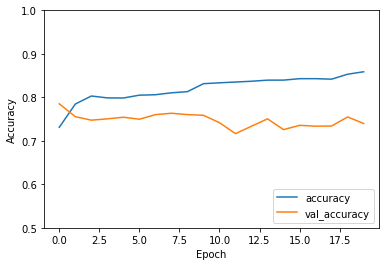

In [138]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## tkk

In [140]:
companies = {}
def get_sample_text(sample):
    assert sample['column'][3]['@name'] == 'text'
    return sample['column'][3]['#text']


def get_sample_answers_bank(sample):
    answers = {}
    for i in range(4, 12):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_answers_tkk(sample):
    answers = {}
    for i in range(4, 11):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_id(sample):
    assert sample['column'][0]['@name'] == 'id'
    return int(sample['column'][0]['#text'])


def get_data(filename):
    df = pd.DataFrame()
    with open(filename, "r", encoding='utf-8') as f:
        d = xmltodict.parse(f.read(), process_namespaces=True)
        clean_samples = []
        for sample in d['pma_xml_export']['database']['table']:
            sample_id = get_sample_id(sample)
            text = get_sample_text(sample)
            answers = get_sample_answers_tkk(sample)
            for company, answer in answers.items():
                if answer is not None:
                    clean_samples.append((sample_id, text, company, answer))
        df['text'] = [sample[1] for sample in clean_samples]
        df['answer'] = [sample[3] for sample in clean_samples]
        df['company'] = [sample[2] for sample in clean_samples]
        df['sample_id'] = [sample[0] for sample in clean_samples]
    return df

In [141]:
train_filename = "SentiRuEval_2016/tkk_train_2016.xml"
test_filename = "SentiRuEval_2016/tkk_test_etalon.xml"

train = get_data(train_filename)
test = get_data(test_filename)

In [142]:
url_replacement = lambda x: re.sub(r'(?:http[^\s]+)($|\s)', r'url\1', x)
user_replacement = lambda x: re.sub(r'(?:@[^\s]+)($|\s)', r'user\1', x)

train['text'] = train['text'].apply(url_replacement)
train['text'] = train['text'].apply(user_replacement)

test['text'] = test['text'].apply(url_replacement)
test['text'] = test['text'].apply(user_replacement)

#### Привели к нормальной форме

In [143]:
%%time
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

ls_train = []
for line in train['text'].str.split():
    words = []
    for word in line:
        p = morph.parse(word)[0]  # делаем разбор
        words.append(p.normal_form)
    ls_train.append(words)

Wall time: 1min 52s


In [144]:
%%time
ls_test = []
words = []
for line in test['text'].str.split():
    words = []
    for word in line:
        p = morph.parse(word)[0]  # делаем разбор
        words.append(p.normal_form)
    ls_test.append(words)

Wall time: 34.7 s


#### Использовать эмбеддинги FastText

In [145]:
%%time
X_embedded_train = []
model = gensim.models.KeyedVectors.load('181/model.model')
for word in ls_train:
    X_embedded_train.append(model[word])

Wall time: 3min


In [146]:
%%time
X_embedded_test = []
for word in ls_test:
    X_embedded_test.append(model[word])

Wall time: 10.3 s


In [147]:
size_word = []
for i in range(len(X_embedded_train)):
    size_word.append(len(X_embedded_train[i]))
max(size_word)

30

In [148]:
size_word_test = []
for i in range(len(X_embedded_test)):
    size_word_test.append(len(X_embedded_test[i]))
max(size_word_test)

31

#### Work with mass size

In [149]:
X_test = np.array(X_embedded_test)
for i in range(len(X_test)):
    size = 31 - X_test[i].shape[0]
    X_test[i] = np.pad(X_test[i], ((0, size), (0, 0)), 'constant', constant_values=(0))

In [150]:
X_train = np.array(X_embedded_train)
for i in range(len(X_train)):
    size = 31 - X_train[i].shape[0]
    X_train[i] = np.pad(X_train[i], ((0, size), (0, 0)), 'constant', constant_values=(0))

In [151]:
X_train1 = []
for i in range(len(X_train)):
    X_train1.append(X_train[i])

In [152]:
X_test1 = []
for i in range(len(X_test)):
    X_test1.append(X_test[i])

In [153]:
X_train1 = np.array(X_train1)
X_test1 = np.array(X_test1)

In [154]:
y_train = np_utils.to_categorical(train['answer'], 3)
y_test = np_utils.to_categorical(test['answer'], 3)

In [155]:
X_train1 = np.expand_dims(X_train1, axis = 3)
X_test1 = np.expand_dims(X_test1, axis = 3)

In [156]:
X_train1.shape

(9209, 31, 300, 1)

#### Keras

In [163]:
%%time

model = Sequential()
model.add(Conv2D(40, kernel_size=(2, 2), 
                 strides=(2, 2), activation='relu', input_shape = (31, 300, 1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(4, 4)))
model.add(Conv2D(80, kernel_size=(2, 2), strides=(2, 2), activation='relu')) 
model.add(MaxPooling2D(pool_size=(2,2), strides=(4, 4)))
model.add(Flatten())
model.add(Dense(100, activation='softmax'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

Wall time: 278 ms


In [164]:
%%time

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

Wall time: 154 ms


In [165]:
%%time

history = model.fit(X_train1, y_train,
                    epochs=40,
                    verbose=False,
                    validation_data=(X_test1, y_test))

Wall time: 9min 38s


In [166]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 15, 150, 40)       200       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 38, 40)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 19, 80)         12880     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 1, 5, 80)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               40100     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)              

In [167]:
loss, accuracy = model.evaluate(X_train1, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test1, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8637
Testing Accuracy:  0.7009


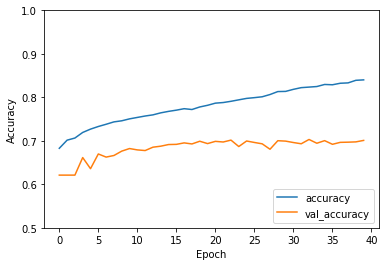

In [168]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')